In [23]:
import torch
import json
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

edge_path = './data/musae_git_edges.csv'
feature_path = './data/musae_git_features.json'

In [2]:
edge_df = pd.read_csv(edge_path)

G = nx.Graph()

G.add_edges_from(edge_df.values)
print(G)

Graph with 37700 nodes and 289003 edges


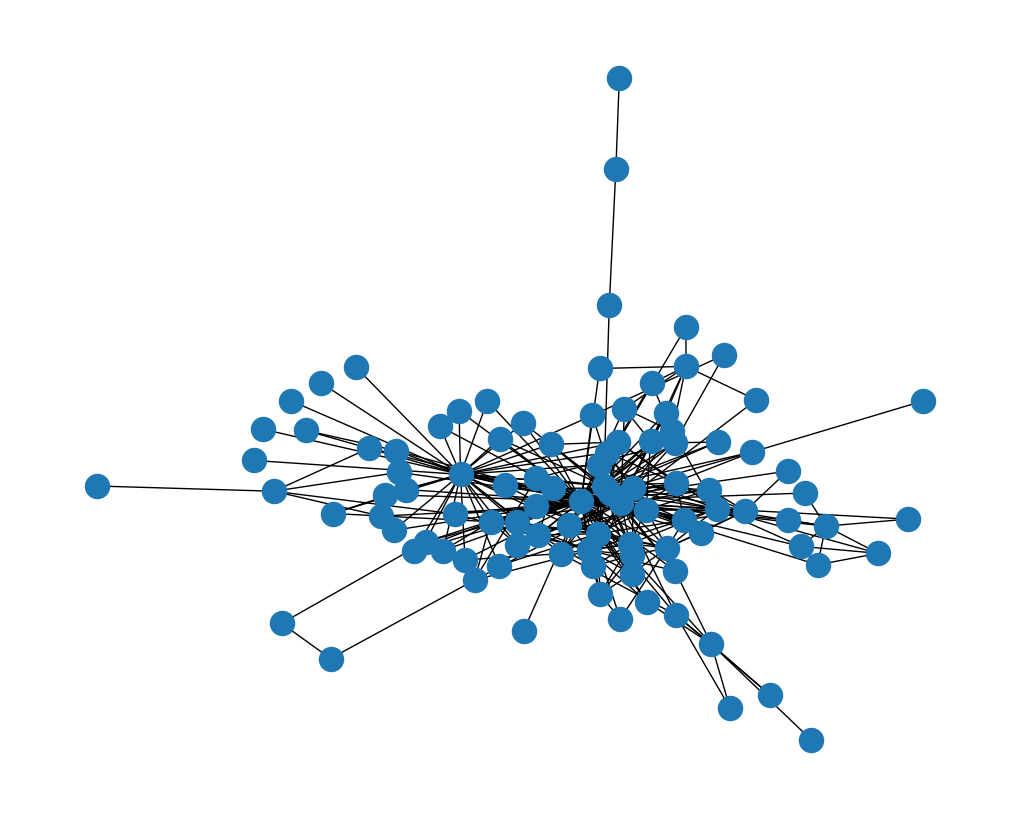

In [3]:
sample_nodes = list(G.nodes)[:100]
sample_subgraph = G.subgraph(sample_nodes)

plt.figure(figsize=(10, 8))
nx.draw(sample_subgraph, node_size=300, font_size=8)
plt.show()

In [4]:
# no isolated nodes
isolated_nodes = [node for node, degree in G.degree() if degree == 0]
print("Number of isolated nodes:", len(isolated_nodes))

# no selfloops
num_selfloops = nx.number_of_selfloops(G)
print("Number of selfloops:", num_selfloops)

# the graph is fully connected
num_components = nx.number_connected_components(G)
print("Number of connected components:", num_components)

Number of isolated nodes: 0
Number of selfloops: 0
Number of connected components: 1


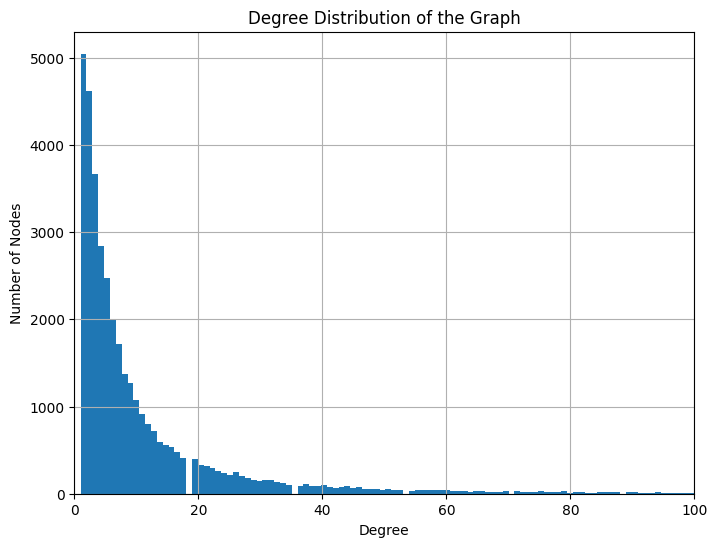

In [5]:
# what does the degree distribution look like for this graph?

# Get the degree of each node
degree_sequence = [degree for _, degree in G.degree()]

# Plot the degree distribution - to help us determine what threshold to set when
# preprocessing
plt.figure(figsize=(8, 6))
plt.xlim(0,100)
plt.hist(degree_sequence, bins=10000)
plt.title("Degree Distribution of the Graph")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.grid(True)
plt.show()

In [6]:
avg_clustering = nx.average_clustering(G)
print("Average clustering coefficient:", avg_clustering)

Average clustering coefficient: 0.1675370448010758


In [8]:
# lengths = dict(nx.all_pairs_shortest_path_length(G))
# sampled_lengths = [l for source in list(lengths.keys())[:100] for l in lengths[source].values()]
# plt.hist(sampled_lengths, bins=30)
# plt.xlabel("Shortest path length")
# plt.ylabel("Count")
# plt.title("Shortest Path Length Distribution (sampled)")
# plt.show()

Min: 8
Max: 42
Mean: 18.31230769230769


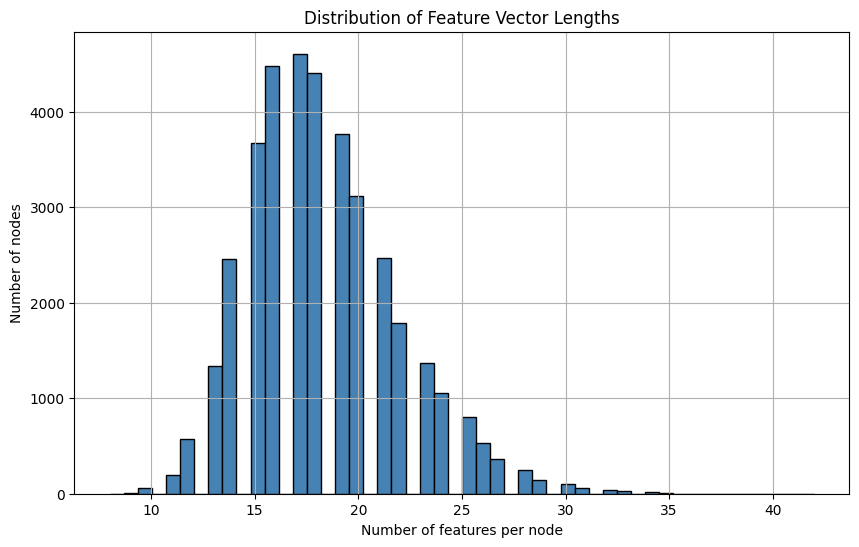

In [9]:
with open(feature_path) as f:
    features_dict = json.load(f)

# Count feature length per node
feature_lengths = [len(feats) for feats in features_dict.values()]

# Basic stats
print("Min:", min(feature_lengths))
print("Max:", max(feature_lengths))
print("Mean:", sum(feature_lengths) / len(feature_lengths))

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(feature_lengths, bins=50, color='steelblue', edgecolor='black')
plt.xlabel("Number of features per node")
plt.ylabel("Number of nodes")
plt.title("Distribution of Feature Vector Lengths")
plt.grid(True)
plt.show()


In [ ]:
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected

# Load edges
edge_df = pd.read_csv(edge_path)
edge_index = torch.tensor(edge_df.values.T, dtype=torch.long)
edge_index = to_undirected(edge_index)

# Load node embeddings
emb_df = pd.read_csv('./data/musae_git_embedding.csv')
# Ensure sorting by node id
emb_df = emb_df.sort_values(by=emb_df.columns[0])
x = torch.tensor(emb_df.iloc[:, 1:].values, dtype=torch.float)  # Exclude id column

# (Optional) Check alignment
assert x.shape[0] == len(set(edge_df['id_1']).union(set(edge_df['id_2']))), "Node count mismatch"

data = Data(x=x, edge_index=edge_index)

print(data)

Data(x=[37700, 512], edge_index=[2, 578006])


In [25]:
import networkx.algorithms.community as nx_comm

# what are the communities in this graph? we want to pick a medium size
# community to accomodate api and memory limits

communities = nx_comm.louvain_communities(G, seed=42)
print(sorted([len(val) for val in communities], reverse=True)[:10])

[8985, 7432, 6640, 4965, 4064, 1954, 1156, 578, 538, 531]


In [26]:
small_graph = [val for val in communities if len(val) == 4965]
G_sub = G.subgraph(small_graph[0]).copy()
print(G_sub)

Graph with 4965 nodes and 18547 edges


In [27]:
# no isolated nodes
isolated_nodes = [node for node, degree in G_sub.degree() if degree == 0]
print("Number of isolated nodes:", len(isolated_nodes))

# no selfloops
num_selfloops = nx.number_of_selfloops(G_sub)
print("Number of selfloops:", num_selfloops)

# the graph is fully connected
num_components = nx.number_connected_components(G_sub)
print("Number of connected components:", num_components)

Number of isolated nodes: 0
Number of selfloops: 0
Number of connected components: 1


In [ ]:
# 1. 获取子图节点及其映射
subgraph_nodes = sorted(G_sub.nodes())
sub_id_map = {old_id: i for i, old_id in enumerate(subgraph_nodes)}

# 2. 子图特征
x_sub = data.x[subgraph_nodes]

# 3. 构建 edge_index
edges = []
for u, v in G_sub.edges():
    edges.append([sub_id_map[u], sub_id_map[v]])
    edges.append([sub_id_map[v], sub_id_map[u]])  # 无向

edge_index_sub = torch.tensor(np.array(edges).T, dtype=torch.long)

# 4. Data 对象
data_sub = Data(x=x_sub, edge_index=edge_index_sub)

print(data_sub)

Data(x=[4965, 512], edge_index=[2, 37094])


In [ ]:
data = torch.load('./data/github_full_data.pt')
data_sub = torch.load('./data/github_sampled_data.pt')